INFO:root:Configuration Summary:
INFO:root:  Data directory: /Data/sar_focusing
INFO:root:  Level from: rcmc
INFO:root:  Level to: az
INFO:root:  Patch size: [1000, 1]
INFO:root:  Batch size: 16
INFO:root:  Save directory: ./visualizations
INFO:root:Creating test dataloader...


{'data_dir': '/Data/sar_focusing', 'epochs': 200, 'lr': '1e-3', 'model': {'name': 'rv_transformer', 'seq_len': 1000, 'input_dim': 2000, 'model_dim': 1024, 'num_layers': 4, 'num_heads': 4, 'ff_dim': 256, 'dropout': 0.1, 'dim_head': 16, 'mode': 'autoregressive', 'dim': 1024, 'depth': 4, 'heads': 4, 'ff_mult': 1}, 'training': {'patience': 20, 'delta': 0.001, 'mode': 'autoregressive', 'device': 'cuda', 'batch_size': 16, 'learning_rate': 0.0001, 'num_epochs': 50, 'save_dir': './visualizations'}, 'dataloader': {'level_from': 'rcmc', 'level_to': 'az', 'num_workers': 0, 'patch_mode': 'rectangular', 'patch_size': [1000, 1], 'buffer': [1000, 1000], 'stride': [1000, 1], 'max_base_sample_size': [10000, 10000], 'shuffle_files': False, 'complex_valued': False, 'save_samples': False, 'backend': 'zarr', 'verbose': False, 'cache_size': 1000, 'online': True, 'positional_encoding': True, 'concatenate_patches': True, 'concat_axis': 0, 'train': {'batch_size': 16, 'samples_per_prod': 100, 'patch_order': 'ro

INFO:root:Created test dataloader with 313 batches
INFO:root:Dataset contains 5000 samples


Loading pretrained weights from: /Data/gdaga/sarpyx_new/sarpyx/training/../results/rv_autoregressive/sar_transformer_best.pth


INFO:root:Starting sample visualization...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Successfully loaded 125 parameters
Dataloader dimension: 313
Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processin

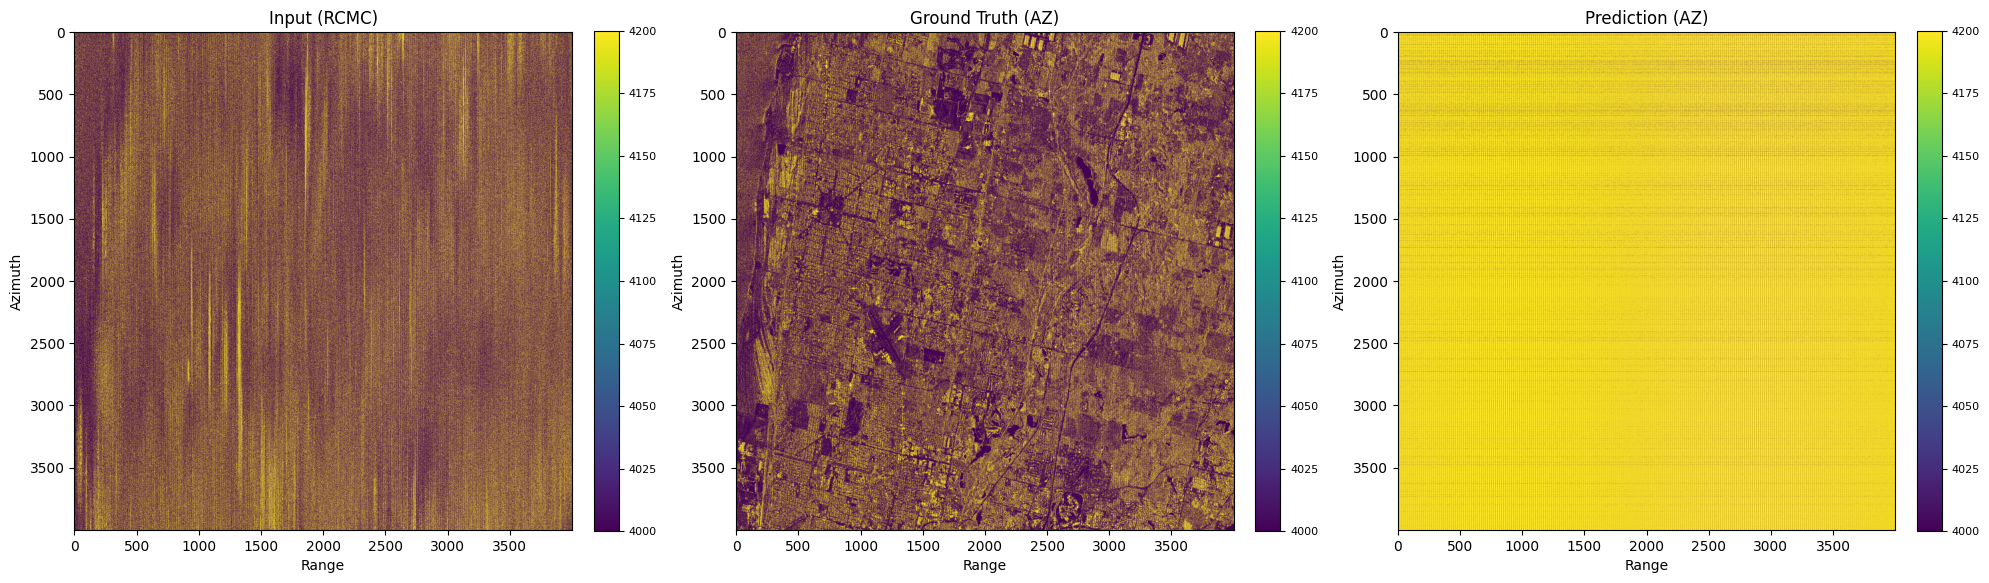

INFO:root:Visualization completed successfully!
INFO:root:Check the visualizations in: ./visualizations


In [1]:
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import yaml
import argparse
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import logging
import time
from typing import Dict, Any
import matplotlib.pyplot as plt

from model.model_utils import get_model_from_configs, create_model_with_pretrained
from training.training_loops import get_training_loop_by_model_name
from training.visualize import save_results_and_metrics, get_full_image_and_prediction, compute_metrics
from sarpyx.utils.losses import get_loss_function
from training_script import load_config
from inference_script import create_test_dataloader
import matplotlib.pyplot as plt
import numpy as np

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("visualization.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def display_inference_results(input_data, gt_data, pred_data, figsize=(20, 6), vminmax=(0, 1000), show: bool=True, save: bool=True, save_path: str="./visualizations"):
    """
    Display input, ground truth, and prediction in a 3-column grid.
    
    Args:
        input_data: Input data from the dataset
        gt_data: Ground truth data
        pred_data: Model prediction
        figsize: Figure size
        vminmax: Value range for visualization
    """
    # Convert tensors to numpy if needed
    if hasattr(input_data, 'numpy'):
        input_data = input_data.cpu().numpy()
    if hasattr(gt_data, 'numpy'):
        gt_data = gt_data.cpu().numpy()
    if hasattr(pred_data, 'numpy'):
        pred_data = pred_data.cpu().numpy()
    
    # Function to get magnitude visualization (similar to get_sample_visualization)
    def get_magnitude_vis(data, vminmax):
        if np.iscomplexobj(data):
            magnitude = np.abs(data)
        else:
            magnitude = data
        
        if vminmax == 'auto':
            vmin, vmax = np.percentile(magnitude, [2, 98])
        elif isinstance(vminmax, tuple):
            vmin, vmax = vminmax
        else:
            vmin, vmax = np.min(magnitude), np.max(magnitude)
        
        return magnitude, vmin, vmax
    
    # Prepare visualizations
    imgs = []
    
    # Input data
    img, vmin, vmax = get_magnitude_vis(input_data, vminmax)
    imgs.append({'name': 'Input (RCMC)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Ground truth
    img, vmin, vmax = get_magnitude_vis(gt_data, vminmax)
    imgs.append({'name': 'Ground Truth (AZ)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Prediction
    img, vmin, vmax = get_magnitude_vis(pred_data, vminmax)
    imgs.append({'name': 'Prediction (AZ)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for i in range(3):
        im = axes[i].imshow(
            imgs[i]['img'],
            aspect='auto',
            cmap='viridis',
            vmin=imgs[i]['vmin'],
            vmax=imgs[i]['vmax']
        )
        
        axes[i].set_title(f"{imgs[i]['name']}")
        axes[i].set_xlabel('Range')
        axes[i].set_ylabel('Azimuth')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
        # Set equal aspect ratio
        axes[i].set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

args = argparse.Namespace(
    config="rv_transformer_autoregressive.yaml",
    device="cuda", 
    batch_size=16,
    save_dir="./visualizations",
    mode="autoregressive",
    pretrained_path=os.path.join(os.getcwd(), '..', 'results', 'rv_autoregressive','sar_transformer_best.pth'), 
    learning_rate=1e-4, 
    num_epochs=50
)

# # Setup logging
logger = setup_logging()
#logger.info(f"Starting visualization with config: {args.config}")

# Load configuration
config = load_config(Path(args.config), args)

# Extract configurations
dataloader_cfg = config['dataloader']
training_cfg = config.get('training', {})

# Override save directory
save_dir = args.save_dir or training_cfg.get('save_dir', './visualizations')

# Log configuration summary
logger.info("Configuration Summary:")
logger.info(f"  Data directory: {dataloader_cfg.get('data_dir', 'Not specified')}")
logger.info(f"  Level from: {dataloader_cfg.get('level_from', 'rcmc')}")
logger.info(f"  Level to: {dataloader_cfg.get('level_to', 'az')}")
logger.info(f"  Patch size: {dataloader_cfg.get('patch_size', [1000, 1])}")
logger.info(f"  Batch size: {dataloader_cfg.get('test', {}).get('batch_size', 'Not specified')}")
logger.info(f"  Save directory: {save_dir}")

# Create test dataloader
logger.info("Creating test dataloader...")
try:
    test_loader = create_test_dataloader(dataloader_cfg)
    logger.info(f"Created test dataloader with {len(test_loader)} batches")
    logger.info(f"Dataset contains {len(test_loader.dataset)} samples")
except Exception as e:
    logger.error(f"Failed to create test dataloader: {str(e)}")
    raise

try:
    model = create_model_with_pretrained(config['model'], pretrained_path=args.pretrained_path, device=args.device)
except Exception as e:
    logger.error(f"Failed to load model: {str(e)}")
    raise

# Visualize samples
logger.info("Starting sample visualization...")
try:
    inference_fn = get_training_loop_by_model_name("rv_transformer_autoregressive", train_loader=test_loader, val_loader=test_loader, test_loader=test_loader, model=model, save_dir=save_dir, mode=args.mode, loss_fn_name="mse")[0].forward
    gt, pred, input = get_full_image_and_prediction(
        dataloader=test_loader,
        show_window=((1000, 1000), (5000, 5000)),
        zfile=0,
        inference_fn=inference_fn,
        return_input=True, 
        device="cuda", 
        vminmax=(4000, 4200)
    )
    print(compute_metrics(gt, pred))
    display_inference_results(
        input_data=input,
        gt_data=gt,
        pred_data=pred,
        figsize=(20, 6),
        vminmax=(4000, 4200),  # Adjust this range based on your data, 
        show=True, 
        save=False
    )
    
    logger.info("Visualization completed successfully!")
    logger.info(f"Check the visualizations in: {save_dir}")
    
except Exception as e:
    logger.error(f"Visualization failed with error: {str(e)}")
    raise